## APPLIED ARTIFICIAL INTELLIGENCE
### STUDENT ID: 202116447

### SUICIDE IDEATION DETECTION

In [74]:
# install packages

!pip install wordcloud
!pip install gensim
!pip install tweet-preprocessor
!pip install keras
!pip install tensorflow

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, precision_score

from time import time
from collections import Counter

import preprocessor as p
import re

import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
from nltk import ngrams

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec


import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, Conv1D, MaxPool1D, Dense, Flatten, SpatialDropout1D, MaxPooling1D
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\molab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\molab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\molab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### IMPORT DATASET

_Dataset from github: https://github.com/laxmimerit/twitter-suicidal-intention-dataset_

In [76]:
# reading the csv files

df = pd.read_csv('twitter-suicidal_data.csv')

In [77]:
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [79]:
df.describe()

,intention
count,9119.000000
mean,0.438425
std,0.496221
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [85]:
df.tail()

,tweet,intention
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1
9118,when cancer takes a life we blame cancer depre...,1


#### DATA CLEANING AND PREPROCESSING

Cleaning Steps:
- Check for null values: remove any if found
- Check for duplicate rows
- Check for whitespaces
- Remove irrelevant words
- Remove hashtags, usernames and special characters

In [88]:
# check for null values

df.isnull().sum()

tweet        0
intention    0
dtype: int64

In [90]:
# check for duplicates
print(df.duplicated().sum())
df[df.duplicated()]

333


,tweet,intention
3924,,0
4047,homework,0
4304,,0
4391,,0
4399,hungry,0
...,...,...
8974,,0
9003,i am here for you,0
9010,i am here for you,0
9038,,0


In [91]:
df['tweet'].nunique()

8785

In [92]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.duplicated().sum()

0

In [93]:
# check for white spaces
print(df['tweet'].str.match('\s\s+').value_counts())

False    8786
Name: tweet, dtype: int64


In [94]:
# check for URLS
print('===Contains URLS===')
print(df['tweet'].str.contains('http').value_counts())

# check for hashtags
print('===Contains hashtags===')
print(df['tweet'].str.match('#(\w+)').value_counts())

# check for mentions
print('===Contains mentions===')
print(df['tweet'].str.match('@(\w+)').value_counts())

===Contains URLS===
False    8786
Name: tweet, dtype: int64
===Contains hashtags===
False    8786
Name: tweet, dtype: int64
===Contains mentions===
False    8786
Name: tweet, dtype: int64


In [95]:
# # To avoid repetition, I will write a function that will do all these together

# # change to lowercase
# # df['tweet'] = df['tweet'].apply(str).map(lambda x: x.lower())

# # # remove digits
# # df['tweet'] = df['tweet'].apply(str).map(lambda x: re.sub('\d+', '', x))

# # # remove punctuations
# # df['tweet'] = df['tweet'].apply(str).map(lambda x: re.sub("[,'\.!?]", '', x))

# # df2.head()
# df1['clean_tweet'] = df1['tweet'].apply(str).map(lambda x: clean_tweet(x))
# # preprocess tweet
# df1['clean_tweet'] = df1['clean_tweet'].apply(str).map(lambda x: preprocess_tweet(x))
# # lemmatize and remove stop words tweet
# df1['clean_tweet'] = df1['clean_tweet'].apply(str).map(lambda x: remove_stopwords(x))
# # final clean
# df1['clean_tweet'] = df1['clean_tweet'].apply(str).map(lambda x: remove_quotes(x))

# df1.sample(n=10)

To remove hashtags, numbers, mentions, emojis, smileys and other possible tweets features easily, I would be using the `tweet_preprocessor package`

In [9]:
def clean_tweet(tweet):
    # strip trailing spaces
    tweet = tweet.strip()
    # change to lowercase
    tweet = tweet.lower()
    # remove digits
    tweet = re.sub('\d+', '', tweet)
    # remove punctuations -
    tweet = re.sub("[,-.'\_*!?]", '', tweet)
    # remove single character
    tweet = re.sub(r"\s+[a-zA-Z]\s+", '', tweet)
    # remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)
    return tweet

def preprocess_tweet(tweet):
    return p.clean(tweet)

*Lemmatization and Tokenization using the `TweetTokenizer()` package*

In [10]:
lemmatizer = nltk.stem.WordNetLemmatizer()
# word_tokenizer = TweetTokenizer()

def lemmatize_text(text):
    return [(lemmatizer.lemmatize(w)) for w in word_tokenize(text)]

stop_words = set(stopwords.words('english'))

def remove_stopwords(tweet):
    w = [item for item in lemmatize_text(tweet) if item not in stop_words]
    return ' '.join(w)

def remove_quotes(text):
    return re.sub('"', '', text)

#### preprocess the tweet and save to another column

In [98]:

# clean tweet
df['clean_tweet'] = df['tweet'].apply(str).map(lambda x: clean_tweet(x))

# preprocess tweet
df['clean_tweet'] = df['clean_tweet'].apply(str).map(lambda x: preprocess_tweet(x))

# lemmatize and remove stop words tweet
df['clean_tweet'] = df['clean_tweet'].apply(str).map(lambda x: remove_stopwords(x))

# final clean
df['clean_tweet'] = df['clean_tweet'].apply(str).map(lambda x: remove_quotes(x))

df.sample(10)

,tweet,intention,clean_tweet
8079,i dont want him to grow old and die,0,dont want grow old die
4890,well he ll just have to make do with us then ...,0,well make u bad tbh
462,i need help ever since i was born my mom would...,1,need help ever since wa born mom would always ...
248,just wishing i was dead,1,wishing wa dead
945,when you are the source of your problems most ...,1,source problem often people want kill problem ...
8447,i know minutes before then i contemplated drow...,0,know minute contemplated drowning dad said rea...
3423,my luck i d probably get stopped by a cop or ...,0,luck probably get stopped cop something stupid
1468,unemployment blues why dont i feel like doing ...,1,unemployment blue dont feel like much help los...
3982,bless this woman has been here for 2hours wait...,0,bless woman ha hour waiting son come pick awww...
2251,amending it tomorrow should i leave a note nob...,1,amending tomorrow leave note nobody going talk...


### visualization

In [99]:
# filter out the needed columns
cleaned_df = df.filter(["clean_tweet", "intention"], axis=1)

cleaned_df

,clean_tweet,intention
0,life meaningless want end life badly life comp...,1
1,muttering wan na die daily month feel worthles...,1
2,work slave really feel like purpose life make ...,1
3,something october overdosed felt alone horribl...,1
4,feel like one care want die maybe feel le lonely,1
...,...,...
8781,ever laid bed night cried good enough counted ...,1
8782,fault blame pain still alone inside broken hom...,1
8783,stop asking trust still coughing water last ti...,1
8784,never know handle sadness cry make feel stupid,1


Total suicidal tweets:  3958
Total non-suicidal tweets:  4828


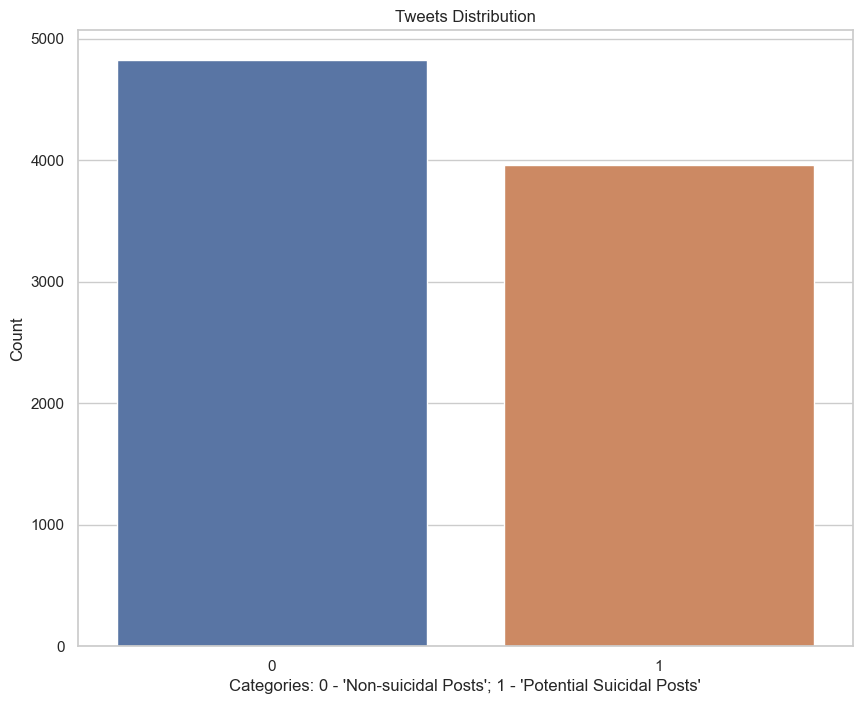

In [100]:
# compare the frequency of suicidal to nonsuicidaltweets
# check class distribution 

print('Total suicidal tweets: ', len(cleaned_df.loc[cleaned_df['intention'] == 1])) 
print('Total non-suicidal tweets: ', len(cleaned_df.loc[cleaned_df['intention'] == 0]))

# plot the counts 
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(10,8))
distribution = sns.countplot(x="intention", data=cleaned_df)
distribution.set_ylabel("Count")
distribution.set_xlabel("Categories: 0 - 'Non-suicidal Posts'; 1 - 'Potential Suicidal Posts'")
plt.title("Tweets Distribution")
plt.savefig('./images/tweet-distribution')
plt.show()

#### let's investigate to top most frequest words (ngrams) in top 10 clean_tweet for each category

In [11]:
# write a function to reduce code repitition
def frequency_words(text, top, labelss):
    """
    finds the top words in a gien text
    text - str
    top - int
    
    rerurns a dataframe contianing the top words and teir cunts
    """
    lst_tokens = nltk.tokenize.word_tokenize(text.str.cat(sep=" "))
    ngrams = [1,2,3]
    
    temp_df = pd.DataFrame()
    
    # for 1,2,3 words get the most freq and their counts, save to the temp df
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        temp_df = pd.concat([temp_df, dtf_n], ignore_index=True) 
    
    # append df in loop to original temporary df
    temp_df["word"] = temp_df["word"].apply(lambda x: " ".join(string for string in x) )
    temp_df = temp_df.sort_values(["ngrams","freq"], ascending=[True,False])
    
    # plot the words
    fig, ax = plt.subplots(figsize=(10,7))
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel= "Words Frequency")
    ax.set(ylabel= "Common Words")
    plt.title(f"Top {top} words per n-grams for {labelss} tweets")
    plt.savefig(f"./images/top-{top}-words-for-{labelss}-tweets")
    plt.show()
    ax.grid(axis="x")
    return temp_df

Category: Potential Suicidal Post


C:\Users\molab\AppData\Local\Temp\ipykernel_13404\4258294514.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))


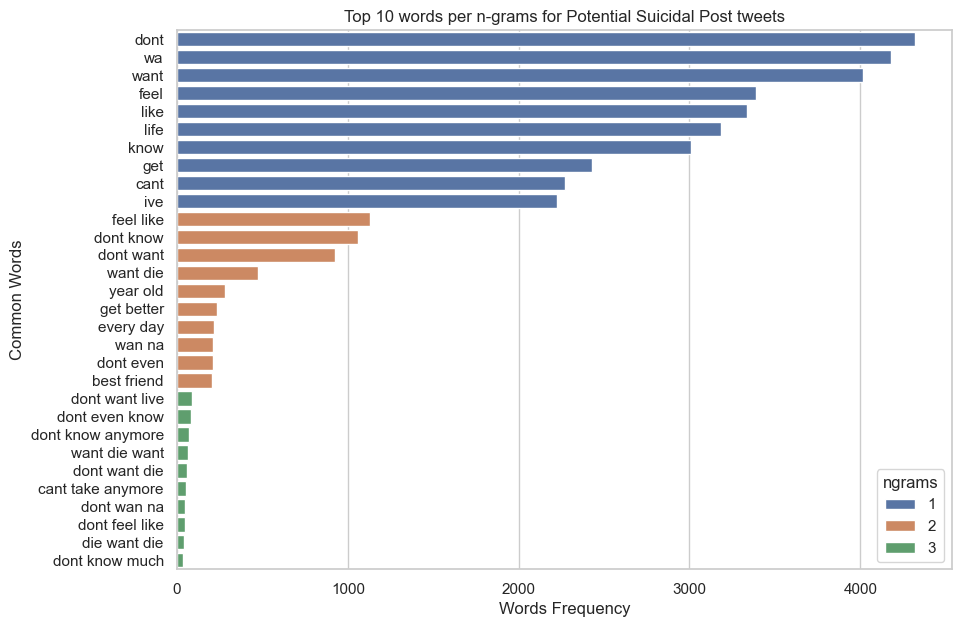

Category: Non Suicidal Post


C:\Users\molab\AppData\Local\Temp\ipykernel_13404\4258294514.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))


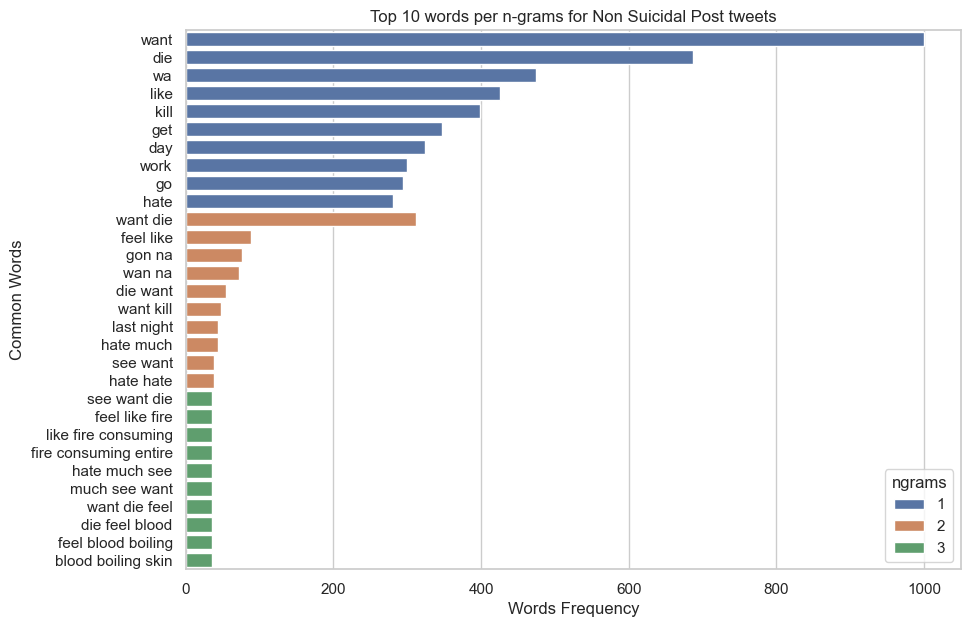

In [102]:
temp_df = pd.DataFrame()
for label in cleaned_df['intention'].unique():
    if label == 1:
        text = 'Potential Suicidal Post'
    else:
        text = 'Non Suicidal Post'
    print('Category: {}'.format(text))
    df_temp = frequency_words(cleaned_df[cleaned_df['intention'] == label]['clean_tweet'], 10, text)
    df_temp['intention'] = label
    temp_df = pd.concat([temp_df, df_temp], ignore_index=True) 

#### similar n-grams, weird.

#### Let's plot the word cloud

In [12]:
def plot_wordcloud(text, labelsss, max_words=100, max_font_size=45):
    """
    plot wordcloud
    
    """
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words)
    wordcloud = wordcloud.generate(str(text))
    fig = plt.figure(figsize=(7,5))
    plt.title(f"Word Cloud for {labelsss} Tweets")
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig(f"./images/{labelsss}-wordcloud")
    plt.show()

Category: Potential Suicidal Post


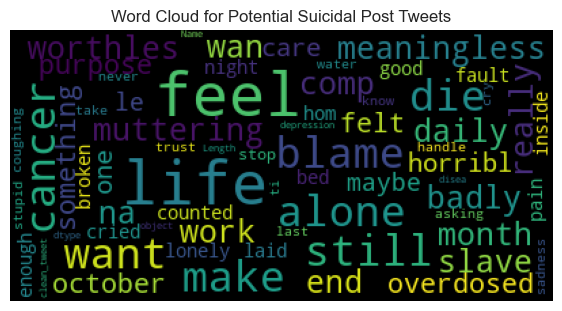

Category: Non Suicidal Post


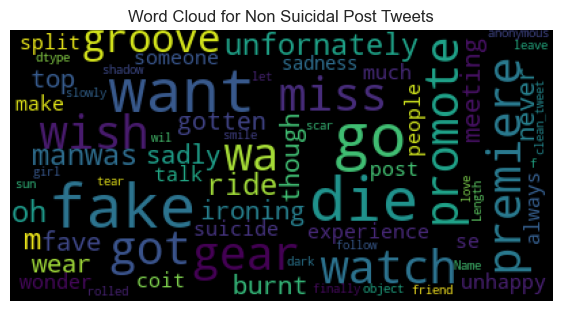

In [105]:
# plot for both categoroes
for label in cleaned_df['intention'].unique():
    if label == 1:
        text = 'Potential Suicidal Post'
    else:
        text = 'Non Suicidal Post'
    print('Category: {}'.format(text))
    plot_wordcloud(cleaned_df[cleaned_df['intention'] == label]['clean_tweet'], text)

#### Let's find the length of each tweet and the number of words in them

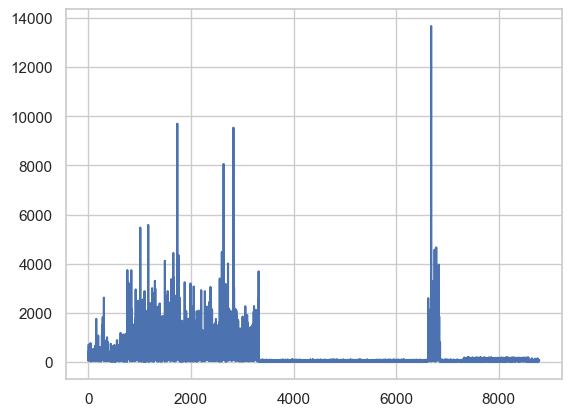

In [106]:
# length distribution of each tweet

line_lengths = [len(tweet) for tweet in cleaned_df['clean_tweet']]
plt.plot(line_lengths)
plt.show()

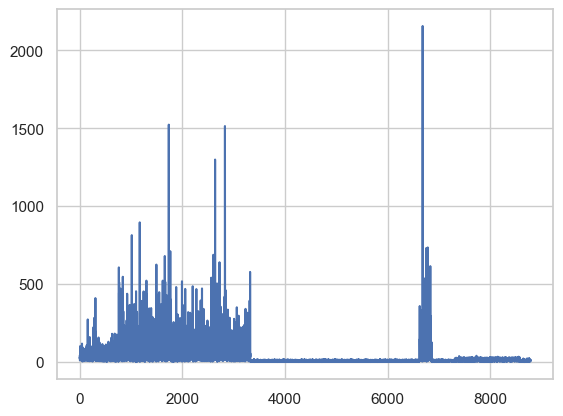

In [107]:
# word distribution in each tweet

number_of_words = ([len(tweet.split()) for tweet in cleaned_df['clean_tweet']])
plt.plot(number_of_words)
plt.show()

*There are too many outliers as the tweets have varying lengths. For better results, I have to use padding*

*Let's find the maximum, minumn, average and modal values of the numbers*

In [110]:
ttt = pd.DataFrame(number_of_words)
print(ttt.describe())
print(ttt.mode())


                 0
count  8786.000000
mean     39.055429
std      74.704993
min       0.000000
25%       6.000000
50%      12.000000
75%      40.000000
max    2156.000000
   0
0  5


*The mean is 39, mode is 5, median is 12, max 2156. I will be making the maximum length 60. This is just right for a tweet*

In [111]:
max_length = 60

In [112]:
cleaned_df = cleaned_df.rename(columns={'clean_tweet': 'text', 'intention': 'class'})
cleaned_df

,text,class
0,life meaningless want end life badly life comp...,1
1,muttering wan na die daily month feel worthles...,1
2,work slave really feel like purpose life make ...,1
3,something october overdosed felt alone horribl...,1
4,feel like one care want die maybe feel le lonely,1
...,...,...
8781,ever laid bed night cried good enough counted ...,1
8782,fault blame pain still alone inside broken hom...,1
8783,stop asking trust still coughing water last ti...,1
8784,never know handle sadness cry make feel stupid,1


#### Split the data to test and train and build the vocabulary
#### convert text to sequences and pad to length 60

In [113]:
x_train, x_test, y_train, y_test = train_test_split(cleaned_df['text'], cleaned_df['class'], random_state=42, test_size=0.2, stratify=cleaned_df['class'])


In [114]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(sequences=x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(sequences=x_test, maxlen=max_length, padding='post')

## Word Embedding with Word2Vec

*Training the word2vec model*

In [115]:
# Train the Word2Vec model
#split tweets into a list of sentences
sentences = [sentence.split() for sentence in cleaned_df['text']]

#build teh model
w2v_model = Word2Vec(sentences, window=5, min_count=4, seed=52, vector_size=100, epochs=15, workers=3)

*Create a weight matrix for the embedding layer*

In [116]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [119]:
# test model

w2v_model.wv.most_similar('death')

[('painful', 0.7444491982460022),
 ('ending', 0.7004335522651672),
 ('painless', 0.686383843421936),
 ('dying', 0.6451078653335571),
 ('fear', 0.6363087892532349),
 ('killing', 0.6227149963378906),
 ('itd', 0.6106684803962708),
 ('escape', 0.6091335415840149),
 ('peace', 0.6076568365097046),
 ('sorrow', 0.57684725522995)]

In [120]:
print(w2v_model)

Word2Vec<vocab=5725, vector_size=100, alpha=0.025>


## Deep Learning Models

### CNN

In [121]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
cnn_model.add(Conv1D(filters=150, kernel_size=5, activation="relu"))
cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(filters=250, kernel_size=5, activation="relu", padding='same'))
cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(filters=300, kernel_size=8, activation="relu", padding='same'))
cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 100)           1918600   
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 150)           75150     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 28, 150)          0         
 1D)                                                             
                                                                 
 dropout_29 (Dropout)        (None, 28, 150)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 28, 250)           187750    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 14, 250)          0         
 1D)                                                  

In [122]:
m_history = cnn_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
198/198 [==============================] - 16s 74ms/step - loss: 0.3022 - acc: 0.8740 - val_loss: 0.2615 - val_acc: 0.8976
Epoch 2/10
198/198 [==============================] - 14s 73ms/step - loss: 0.2115 - acc: 0.9140 - val_loss: 0.2445 - val_acc: 0.9047
Epoch 3/10
198/198 [==============================] - 14s 73ms/step - loss: 0.1689 - acc: 0.9298 - val_loss: 0.2372 - val_acc: 0.9018
Epoch 4/10
198/198 [==============================] - 14s 72ms/step - loss: 0.1281 - acc: 0.9523 - val_loss: 0.2642 - val_acc: 0.9033
Epoch 5/10
198/198 [==============================] - 15s 74ms/step - loss: 0.1010 - acc: 0.9597 - val_loss: 0.2614 - val_acc: 0.9104
Epoch 6/10
198/198 [==============================] - 15s 74ms/step - loss: 0.0893 - acc: 0.9682 - val_loss: 0.3404 - val_acc: 0.8990
Epoch 7/10
198/198 [==============================] - 15s 73ms/step - loss: 0.0608 - acc: 0.9787 - val_loss: 0.3634 - val_acc: 0.9075
Epoch 8/10
198/198 [==============================] - 15s 73ms

In [123]:
results_1 = cnn_model.evaluate(x_test, y_test, verbose=False)

In [124]:
print(f"Loss: {results_1[0]}; Accuracy: {100*results_1[1]}%")

Loss: 0.49561557173728943; Accuracy: 90.95563292503357%


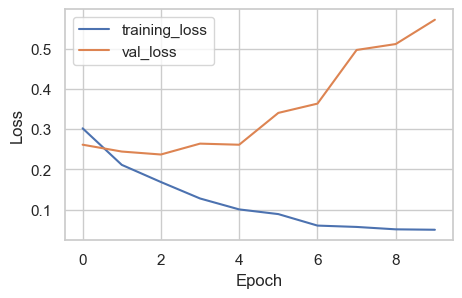

In [125]:
# visualize training and accuracy
# check for overfitting
m_history_df = pd.DataFrame(m_history.history)
plt.figure(figsize=(5,3))
plt.plot(m_history_df['loss'], label='training_loss')
plt.plot(m_history_df['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [126]:
# prediction
def predict_tweet(tweet, model):
    twt = tokenizer.texts_to_sequences(tweet)
    twt = pad_sequences(twt, maxlen=60, padding='post')
    predicted = model.predict(twt, batch_size=3, verbose=True)
    print(np.argmax(predicted))
    if(np.argmax(predicted) == 1):
        print("Potential Suicidal Post")
    elif(np.argmax(predicted) == 0):
        print("Non Suicidal Post")
    else:
        print(np.argmax(predicted))
        
# prediction
def prediction_tweet(tweet, model):
    a = clean_tweet(tweet)
    b = preprocess_tweet(a)
    c = remove_stopwords(b)
    d = remove_quotes(c)
    twt = tokenizer.texts_to_sequences(d)
    twt = pad_sequences(twt, maxlen=60, padding='post', dtype='int32')
    predicted = model.predict(twt, batch_size=3, verbose=True)
    print(np.argmax(predicted))
    if(np.argmax(predicted) == 1):
        print("Potential Suicidal Post")
    elif(np.argmax(predicted) == 0):
        print("Non Suicidal Post")
    else:
        print(np.argmax(predicted))

In [127]:
test_tweet = "I am doing great, let's see what tomorrow brings"

predict_tweet(test_tweet, cnn_model)

prediction_tweet(test_tweet, cnn_model)

16/16 [==============================] - 0s 3ms/step
0
Non Suicidal Post
10/10 [==============================] - 0s 5ms/step
3
3


In [128]:
test_tweet2 = "I don't like it here anymore, can I just go away?"

predict_tweet(test_tweet2, cnn_model)

prediction_tweet(test_tweet2, cnn_model)

17/17 [==============================] - 0s 3ms/step
48
48
7/7 [==============================] - 0s 3ms/step
1
Potential Suicidal Post


In [129]:
test_tweet3 = "I feel worthless. Would be great if I wasn't here anymore. byeeee"

predict_tweet(test_tweet3, cnn_model)

prediction_tweet(test_tweet3, cnn_model)

22/22 [==============================] - 0s 3ms/step
0
Non Suicidal Post
14/14 [==============================] - 0s 3ms/step
4
4


In [130]:
test_tweet4 = "I want to kill myself"

predict_tweet(test_tweet4, cnn_model)

prediction_tweet(test_tweet4, cnn_model)

7/7 [==============================] - 0s 3ms/step
0
Non Suicidal Post
3/3 [==============================] - 0s 0s/step
0
Non Suicidal Post


### CNN + LSTM Model

In [131]:
lstm_cnn_model = Sequential()
lstm_cnn_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
lstm_cnn_model.add(SpatialDropout1D(0.6))

lstm_cnn_model.add(Conv1D(filters=150, kernel_size=6, padding='same', activation='relu'))
lstm_cnn_model.add(MaxPooling1D(pool_size=2))

lstm_cnn_model.add(Conv1D(filters=200, kernel_size=6, activation='relu'))
lstm_cnn_model.add(MaxPooling1D(pool_size=2))

lstm_cnn_model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
lstm_cnn_model.add(Dropout(0.3))

lstm_cnn_model.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
lstm_cnn_model.add(Dropout(0.3))

lstm_cnn_model.add(Flatten())
lstm_cnn_model.add(Dense(64, activation='relu'))
lstm_cnn_model.add(Dropout(0.5))
lstm_cnn_model.add(Dense(1, activation='sigmoid'))

lstm_cnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])
lstm_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 100)           1918600   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 60, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_10 (Conv1D)          (None, 60, 150)           90150     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 30, 150)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 25, 200)           180200    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 12, 200)         

In [132]:
m_history_2 = lstm_cnn_model.fit(x_train, y_train, batch_size=32, epochs=8, validation_split=0.1)

Epoch 1/8
198/198 [==============================] - 54s 221ms/step - loss: 0.3431 - acc: 0.8506 - val_loss: 0.2792 - val_acc: 0.8890
Epoch 2/8
198/198 [==============================] - 42s 210ms/step - loss: 0.2973 - acc: 0.8735 - val_loss: 0.2686 - val_acc: 0.8748
Epoch 3/8
198/198 [==============================] - 41s 207ms/step - loss: 0.2737 - acc: 0.8840 - val_loss: 0.2513 - val_acc: 0.8919
Epoch 4/8
198/198 [==============================] - 41s 207ms/step - loss: 0.2696 - acc: 0.8882 - val_loss: 0.2357 - val_acc: 0.9061
Epoch 5/8
198/198 [==============================] - 41s 209ms/step - loss: 0.2499 - acc: 0.8933 - val_loss: 0.2630 - val_acc: 0.8890
Epoch 6/8
198/198 [==============================] - 42s 210ms/step - loss: 0.2373 - acc: 0.9056 - val_loss: 0.2358 - val_acc: 0.8962
Epoch 7/8
198/198 [==============================] - 41s 207ms/step - loss: 0.2322 - acc: 0.9053 - val_loss: 0.2359 - val_acc: 0.9047
Epoch 8/8
198/198 [==============================] - 42s 213ms

In [133]:

results_2 = lstm_cnn_model.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {results_2[0]}; Accuracy: {100*results_2[1]}%")

Loss: 0.19644556939601898; Accuracy: 91.52445793151855%


In [169]:
results_2

[0.19644556939601898, 0.9152445793151855]

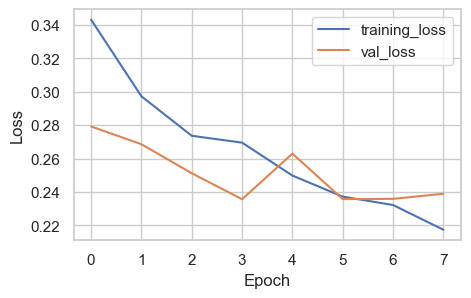

In [134]:
# visualize training and accuracy
# check for overfitting
m_history_df2 = pd.DataFrame(m_history_2.history)
plt.figure(figsize=(5,3))
plt.plot(m_history_df2['loss'], label='training_loss')
plt.plot(m_history_df2['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### BERT

In [148]:
!pip install ktrain

     ---------------------------------------- 25.3/25.3 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 981.5/981.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 19.2/19.2 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 653.6/653.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 977.8/977.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with st

In [151]:
import ktrain

from ktrain import text

In [152]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(cleaned_df['text'], cleaned_df['class'], test_size=0.2, random_state=42)

In [154]:
x_train2 = x_train2.tolist()
x_test2 = x_test2.tolist()
y_train2 = y_train2.tolist()
y_test2 = y_test2.tolist()

In [155]:
class_names = ['Non suicidal text', 'Potential suicidal text']

In [157]:
(xx_train, yy_train), (xx_val, yy_val), preproc = text.texts_from_array(x_train = x_train2, y_train = y_train2,
                                                                       x_test = x_test2, y_test = y_test2,
                                                                       class_names = class_names,
                                                                       preprocess_mode = 'bert',
                                                                       maxlen=60, 
                                                                       max_features=5000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [158]:
bert_model = text.text_classifier('bert', train_data=(xx_train, yy_train), preproc=preproc)

Is Multi-Label? False
maxlen is 60


C:\Users\molab\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [160]:
bert_learner = ktrain.get_learner(bert_model, train_data=(xx_train, yy_train), val_data=(xx_val, yy_val), batch_size=16)

In [161]:
bert_learner.fit_onecycle(2e-5, 10)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
440/440 [==============================] - 2475s 6s/step - loss: 0.3727 - accuracy: 0.8361 - val_loss: 0.2076 - val_accuracy: 0.9152
Epoch 2/10
440/440 [==============================] - 3323s 8s/step - loss: 0.1961 - accuracy: 0.9225 - val_loss: 0.2067 - val_accuracy: 0.9118
Epoch 3/10
440/440 [==============================] - 2767s 6s/step - loss: 0.1277 - accuracy: 0.9509 - val_loss: 0.1862 - val_accuracy: 0.9283
Epoch 4/10
440/440 [==============================] - 7117s 16s/step - loss: 0.0828 - accuracy: 0.9698 - val_loss: 0.1894 - val_accuracy: 0.9306
Epoch 5/10
440/440 [==============================] - 22423s 51s/step - loss: 0.0516 - accuracy: 0.9821 - val_loss: 0.2122 - val_accuracy: 0.9283
Epoch 6/10
440/440 [==============================] - 3470s 8s/step - loss: 0.0363 - accuracy: 0.9859 - val_loss: 0.2580 - val_accuracy: 0.9352
Epoch 7/10
440/440 [==============================] - 2401s 5s/step - 

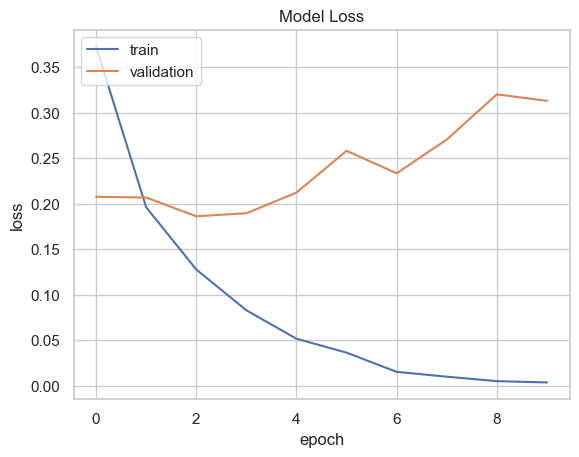

In [162]:
bert_learner.plot()

In [163]:
bert_learner.validate(val_data = (xx_val, yy_val), class_names=class_names)

55/55 [==============================] - 158s 3s/step
                         precision    recall  f1-score   support

      Non suicidal text       0.93      0.96      0.94       938
Potential suicidal text       0.95      0.92      0.93       820

               accuracy                           0.94      1758
              macro avg       0.94      0.94      0.94      1758
           weighted avg       0.94      0.94      0.94      1758



array([[901,  37],
       [ 68, 752]], dtype=int64)

In [165]:
bert_predictor = ktrain.get_predictor(bert_learner.model, preproc)
bert_predictor.get_classes()

['Non suicidal text', 'Potential suicidal text']

In [166]:
test_tweet3 = "I feel worthless. Would be great if I wasn't here anymore. byeeee"

ans = bert_predictor.predict(test_tweet3)

print(ans)

Non suicidal text


In [167]:
test_tweet = "I am doing great, let's see what tomorrow brings"

ans2 = bert_predictor.predict(test_tweet)

print(ans2)

Non suicidal text


In [168]:
test_tweet = "I want to die"

ans2 = bert_predictor.predict(test_tweet)

print(ans2)

Potential suicidal text


In [187]:
test_tweet3 = "Don't call me. I won't pick. I'm done. Can't take this anymore. Tell my people I love them but i hate my life"

ans = bert_predictor.predict(test_tweet3)

print(ans)

Potential suicidal text
